# Imports

In [ ]:
import tensorflow as tf
import os
import shutil
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import cluster as Cluster

In [ ]:
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../utils')))

In [3]:
from data_processing import (
    load_images, load_hierarchy, create_metadata_df, normalize
)
from model_training import (
    compute_embeddings, train_classifier, prepare_train_test_data
)
from evaluation import (
    report_classification, compute_adjusted_rand, plot_scatter, plot_classification_results,
    run_clustering_grid_search, plot_hierarchical_dendrogram
)

/Users/ariskoutris/Software/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
WORK_DIR = '/Users/ariskoutris/Library/CloudStorage/OneDrive-Personal/Programming/wordnet_diffusion'
DATA_DIR = f'{WORK_DIR}/data'
IMG_DIR = f'{DATA_DIR}/images'
VEC_DIR = f'{DATA_DIR}/vectors'
LOG_DIR = f'{DATA_DIR}/tensorboard_logs'
HIERARCHY_DIR = f'{DATA_DIR}/hierarchies'

# Load Images

In [6]:
root_category = 'Dog'
image_data = load_images(root_category, IMG_DIR)
img_arrs    = image_data["img_arrs"]
ids         = image_data["ids"]
filenames   = image_data["filenames"]
dates       = image_data["dates"]
labels      = image_data["labels"]
seq_nums    = image_data["seq_nums"]
seeds       = image_data["seeds"]

# Log to Tensorboard

In [7]:
clear_logs = False
if clear_logs:
    shutil.rmtree(LOG_DIR)
    os.makedirs(LOG_DIR)

In [8]:
log_images = False

if log_images:
  log_subdir = f"{LOG_DIR}/image_data/{root_category}/"
  log_subdir += datetime.now().strftime("%Y%m%d-%H%M%S")

  clear_logs = True
  if clear_logs:
      if os.path.exists(log_subdir):
          shutil.rmtree(log_subdir)
      os.makedirs(log_subdir)

  xs_norm = np.stack([ normalize(arr) for arr in img_arrs ])

  filewriter = tf.summary.create_file_writer(log_subdir)
  with filewriter.as_default():
    tf.summary.image(f"{root_category}", xs_norm, step=0, max_outputs=len(xs_norm))

# Compute Embeddings

Use the compute_embeddings function from model_training.py

In [10]:
save_path = f'{VEC_DIR}/npy/'
load_vectors = True

if load_vectors:
    vecs = np.load(f'{save_path}/dog.npy')
else:
    vecs = compute_embeddings(img_arrs, batch_size=16)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    print(f'Saving embeddings to {save_path}/dog_new.npy')
    np.save(f'{save_path}/dog.npy', vecs)

# Import Wordnet Metadata

In [12]:
hier_df = load_hierarchy(root_category, HIERARCHY_DIR)
tensorboard_metadata = create_metadata_df(image_data, hier_df)

In [13]:
tensorboard_metadata.head()

,class,cat_depth_0,cat_depth_1,cat_depth_2,frequency
0,Eskimo Dog,Dog,Working Dog,Eskimo Dog,0
1,Eskimo Dog,Dog,Working Dog,Eskimo Dog,0
2,Eskimo Dog,Dog,Working Dog,Eskimo Dog,0
3,Eskimo Dog,Dog,Working Dog,Eskimo Dog,0
4,Eskimo Dog,Dog,Working Dog,Eskimo Dog,0


# Classification<br>
We expect that using hyponyms H of a term T as input prompts will yield images whose embeddings fall withing the region of term T's image embeddings.<br>
<br>
To evaluate stable diffusion's ability to conform to wordnet's hierarchy we classifiy hyponyms of depth 2 (e.g. Dog/Spitz/Pomeranian) to depth 1 categories (e.g. Dog/Spitz). <br>
<br>
For that purpose we use images of depth 1 (e.g. generated from Spitz) as training points to predict the depth 1 category of depth 2 images (eg generated from Pomeranian)

Prepare data for classification and then train the classifier

In [14]:
# First split the data
x_train, y_train, x_test, y_test, train_df, test_df, enc = prepare_train_test_data(
    vecs, tensorboard_metadata, depth1_only=True, encode_labels=True)

# Now train the classifier using the split data
clf, pca, x_train_nd, x_test_nd, preds_train, preds_test = train_classifier(
    x_train, y_train, x_test)

Visualize class distributions

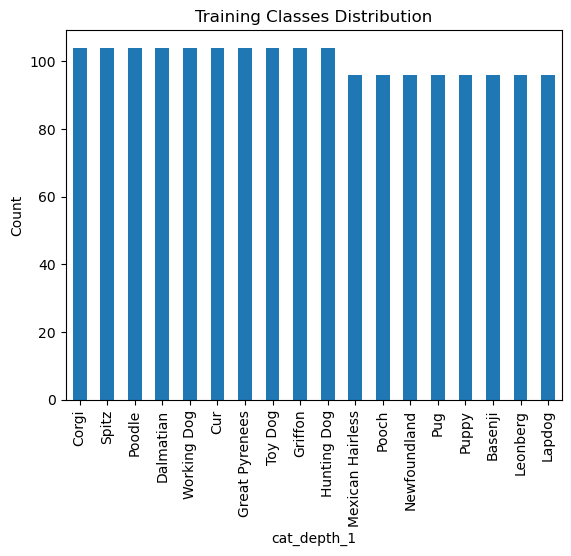

In [15]:
train_df.cat_depth_1.value_counts().plot.bar(ylabel='Count')
plt.title('Training Classes Distribution')
plt.show()

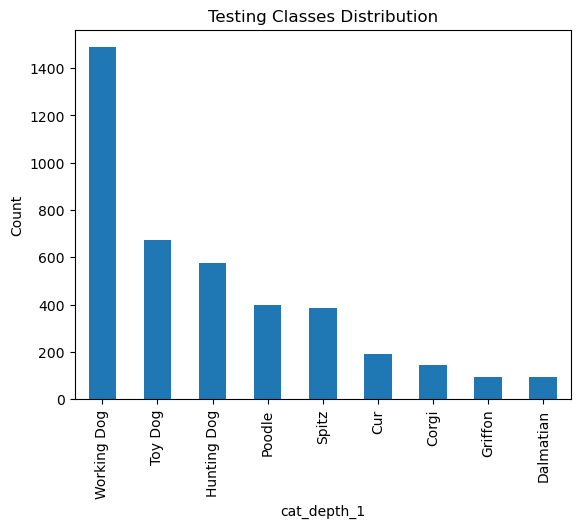

In [16]:
test_df.cat_depth_1.value_counts().plot.bar(ylabel='Count')
plt.title('Testing Classes Distribution')
plt.show()

Create 2D projections for visualization

In [17]:
pca_2d = PCA(n_components=2)
x_train_2d = pca_2d.fit_transform(x_train)  # Fit and transform on training data
x_test_2d = pca_2d.transform(x_test)  # Only apply transformation to test data

Make predictions

In [18]:
labels = np.unique(y_test)
target_names = enc.inverse_transform(labels.reshape(-1, 1)).flatten()

Generate classification reports

In [19]:
print(f"Training set")
_ = report_classification(y_train, preds_train, labels, target_names, digits=2)
print(f"Test set")
_ = report_classification(y_test, preds_test, labels, target_names, digits=2)

Training set
              precision    recall  f1-score   support

       Corgi       0.65      0.83      0.73       104
         Cur       0.73      0.60      0.66       104
   Dalmatian       0.60      0.65      0.63       104
     Griffon       0.71      0.63      0.67       104
 Hunting Dog       0.84      0.68      0.75       104
      Poodle       0.60      0.45      0.52       104
       Spitz       0.98      0.76      0.85       104
     Toy Dog       0.69      0.57      0.62       104
 Working Dog       0.42      0.40      0.41       104

   micro avg       0.68      0.62      0.65       936
   macro avg       0.69      0.62      0.65       936
weighted avg       0.69      0.62      0.65       936

Test set
              precision    recall  f1-score   support

       Corgi       0.02      0.01      0.02       144
         Cur       0.00      0.00      0.00       192
   Dalmatian       0.00      0.00      0.00        96
     Griffon       0.12      0.36      0.18        96
 H

Visualize classification results

Plotting classification results


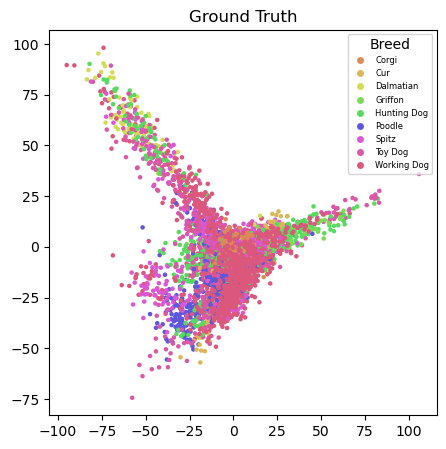

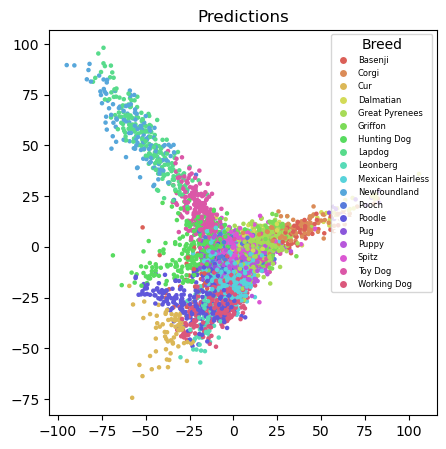

In [20]:
print(f"Plotting classification results")
_ = plot_classification_results(x_test_2d, y_test, preds_test, enc)

# Clustering Analysis

Prepare data for clustering (using depth2 as target)

In [21]:
x_train, y_train, x_test, y_test, train_df, test_df, enc = prepare_train_test_data(
    vecs, tensorboard_metadata, depth1_only=False, encode_labels=True)

Calculate sample weights to handle class imbalance

In [22]:
sample_weights = 1/(test_df[['cat_depth_1']].merge(
    pd.DataFrame(test_df.cat_depth_1.value_counts()), 
    left_on='cat_depth_1', right_index=True).iloc[:,-1].values/test_df.cat_depth_1.value_counts().min())

Visualize data distributions for clustering

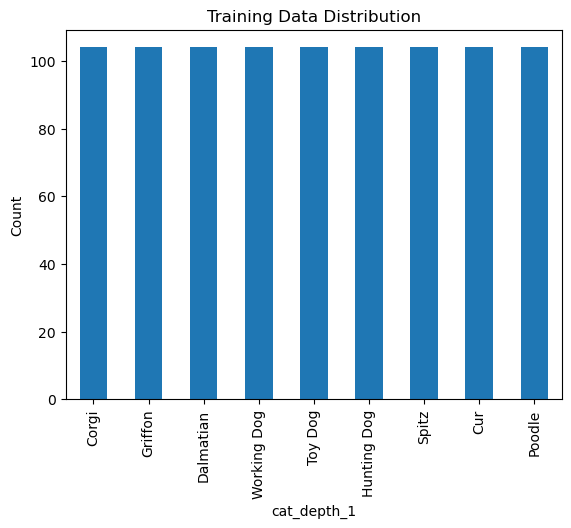

In [23]:
train_df.cat_depth_1.value_counts().plot.bar(ylabel='Count')
plt.title('Training Data Distribution')
plt.show()

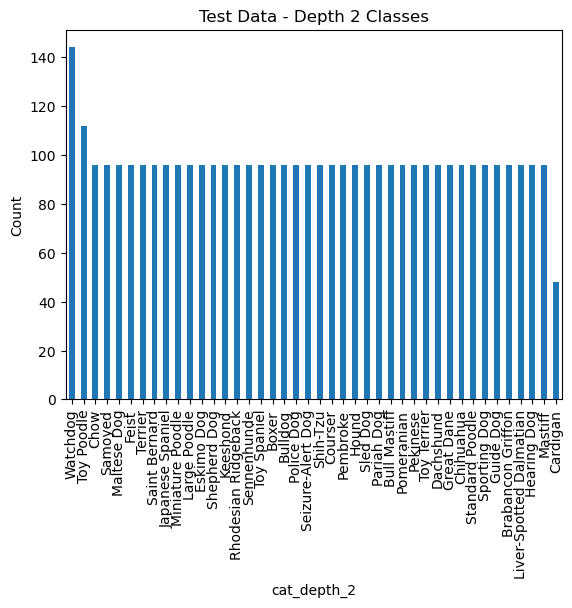

In [24]:
test_df.cat_depth_2.value_counts().plot.bar(ylabel='Count')
plt.title('Test Data - Depth 2 Classes')
plt.show()

## KMeans Clustering

Grid search for KMeans parameters

In [ ]:
kmeans_scores = run_clustering_grid_search(
    x_test, y_test, 
    n_components_list=[-1, 5, 10, 20, 50, 100, 200, 500],
    n_clusters_range=range(37, 47),
    algorithm="kmeans",
    sample_weights=sample_weights
)

Show top 5 configurations

In [27]:
print("Best KMeans configurations:")
for score, params in kmeans_scores[:5]:
    print(f"Score: {score:.4f}, Parameters: {params}")

Best KMeans configurations:
Score: 0.2520, Parameters: {'n_clusters': 46, 'algo': 'lloyd', 'n_components': 100}
Score: 0.2513, Parameters: {'n_clusters': 43, 'algo': 'elkan', 'n_components': 200}
Score: 0.2503, Parameters: {'n_clusters': 40, 'algo': 'elkan', 'n_components': 100}
Score: 0.2502, Parameters: {'n_clusters': 45, 'algo': 'lloyd', 'n_components': 100}
Score: 0.2485, Parameters: {'n_clusters': 41, 'algo': 'elkan', 'n_components': 50}


Run best KMeans configuration

In [40]:
pca = PCA(n_components=100)
x_test_nd = pca.fit_transform(x_test)
x_train_nd = pca.transform(x_train)

In [41]:
model = Cluster.KMeans(n_clusters=46, n_init="auto", tol=1e-4, max_iter=300, algorithm='lloyd')
test_preds = model.fit_predict(x_test_nd)
compute_adjusted_rand(y_test, test_preds)

Adjusted Rand Score: 0.2470012627011607


0.2470012627011607

Create 2D projections for visualization

In [42]:
pca = PCA(n_components=2)
x_train_2d = pca.fit_transform(x_train)  # Fit and transform on training data
x_test_2d = pca.transform(x_test)  # Only apply transformation to test data

Visualize clusters

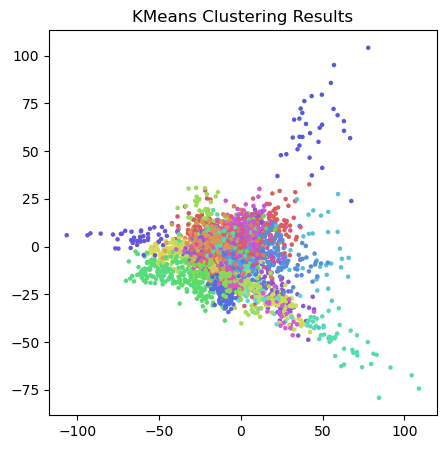

In [43]:
plot_scatter(x_test_2d, test_preds, title='KMeans Clustering Results')

## Hierarchical Clustering

Grid search for Agglomerative Clustering parameters

In [ ]:
agglom_scores = run_clustering_grid_search(
    x_test, y_test,
    n_components_list=[10, 15, 20, 25, 30],
    n_clusters_range=range(35, 45),
    algorithm="agglomerative",
    linkage=['ward', 'average', 'complete'],
    metric=["euclidean", "cosine"]
)

Show top 5 configurations

In [49]:
print("Best Agglomerative Clustering configurations:")
for score, params in agglom_scores[:5]:
    print(f"Score: {score:.4f}, Parameters: {params}")

Best Agglomerative Clustering configurations:
Score: 0.2594, Parameters: {'n_clusters': 43, 'linkage': 'ward', 'metric': 'euclidean', 'n_components': 30}
Score: 0.2585, Parameters: {'n_clusters': 39, 'linkage': 'ward', 'metric': 'euclidean', 'n_components': 30}
Score: 0.2580, Parameters: {'n_clusters': 44, 'linkage': 'ward', 'metric': 'euclidean', 'n_components': 30}
Score: 0.2568, Parameters: {'n_clusters': 40, 'linkage': 'ward', 'metric': 'euclidean', 'n_components': 30}
Score: 0.2555, Parameters: {'n_clusters': 41, 'linkage': 'ward', 'metric': 'euclidean', 'n_components': 30}


Run best hierarchical clustering configuration

In [50]:
pca = PCA(n_components=30)
x_test_nd = pca.fit_transform(x_test)
x_train_nd = pca.transform(x_train)

In [51]:
model = Cluster.AgglomerativeClustering(
    n_clusters=43, linkage="ward", metric='euclidean', 
    connectivity=None, compute_distances=True, compute_full_tree=False
)
test_preds = model.fit_predict(x_test_nd)
compute_adjusted_rand(y_test, test_preds)

Adjusted Rand Score: 0.2547843316946568


0.2547843316946568

# Dendrogram Visualization

Create hierarchical clustering model with full tree for visualization

In [52]:
model = Cluster.AgglomerativeClustering(
    n_clusters=43, linkage="ward", metric='euclidean', 
    connectivity=None, compute_distances=True, compute_full_tree=True
)
test_preds = model.fit_predict(x_test)

Plot dendrogram for test data (depth 2 categories)

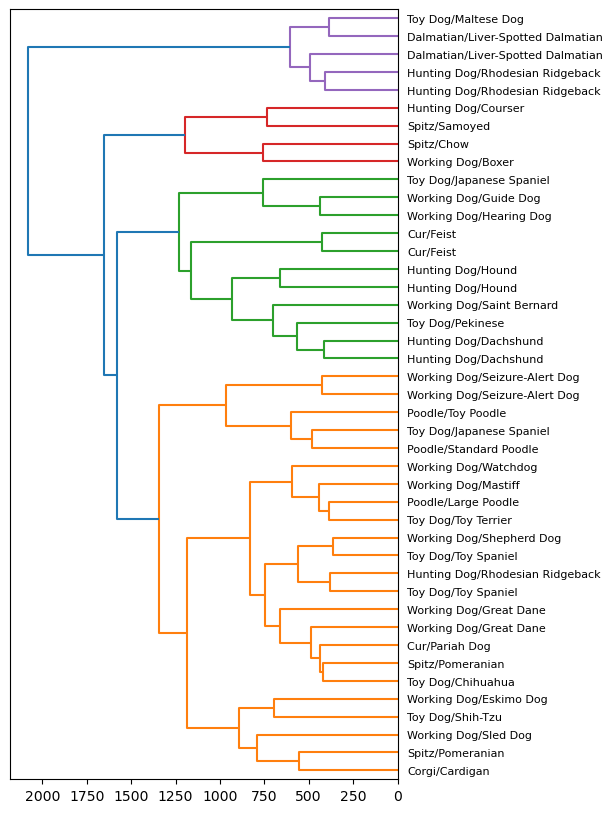

In [53]:
plot_hierarchical_dendrogram(
    model, test_df, 'cat_depth_2', 
    hier_df=hier_df, category_depth=2,
    figsize=(5, 10), orientation='left'
)

Create a model for the training data

In [54]:
model_train = Cluster.AgglomerativeClustering(
    n_clusters=41, linkage="ward", metric='euclidean', 
    connectivity=None, compute_distances=True, compute_full_tree=True
)
train_preds = model_train.fit_predict(x_train)

Plot dendrogram for training data (depth 1 categories)

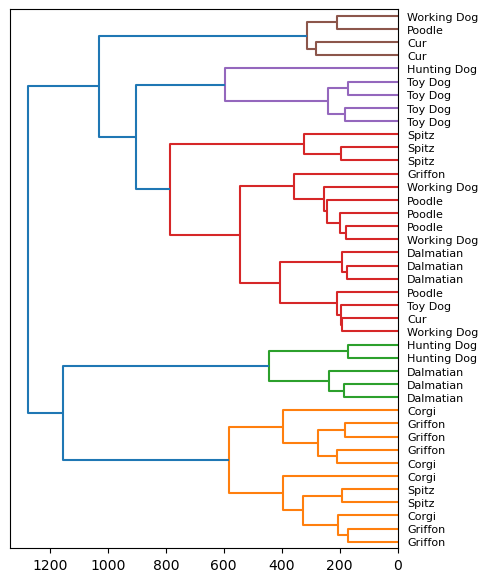

In [55]:
plot_hierarchical_dendrogram(
    model_train, train_df, 'cat_depth_1', 
    figsize=(5, 7), orientation='left'
)